# Fine-tuning for Video Classification with 🤗 Transformers

This notebook shows how to fine-tune a pre-trained Vision model for Video Classification on a custom dataset. The idea is to add a randomly initialized classification head on top of a pre-trained encoder and fine-tune the model altogether on a labeled dataset.


## Dataset

This notebook uses a subset of the [UCF-101 dataset](https://www.crcv.ucf.edu/data/UCF101.php). We'll be using a subset of the dataset to keep the runtime of the tutorial short. The subset was prepared using [this notebook](https://drive.google.com/file/d/1tTScjnyiKrBz84jKe1H_hPGGXffAZuxX/view?usp=sharing) following [this guide](https://www.tensorflow.org/tutorials/load_data/video). 

## Model

We'll fine-tune the [VideoMAE model](https://huggingface.co/docs/transformers/model_doc/videomae), which was pre-trained on the [Kinetics 400 dataset](https://www.deepmind.com/open-source/kinetics). You can find the other variants of VideoMAE available on 🤗 Hub [here](https://huggingface.co/models?search=videomae). You can also extend this notebook to use other video models such as [X-CLIP](https://huggingface.co/docs/transformers/model_doc/xclip#transformers.XCLIPVisionModel). 

**Note** that for models where there's no classification head already available you'll have to manually attach it (randomly initialized). But this is not the case for VideoMAE since we already have a [`VideoMAEForVideoClassification`](https://huggingface.co/docs/transformers/model_doc/xclip#transformers.XCLIPVisionModel) class.

## Data preprocessing

This notebook leverages [TorchVision's](https://pytorch.org/vision/stable/transforms.html) and [PyTorchVideo's](https://pytorchvideo.org/) transforms for applying data preprocessing transformations including data augmentation.

---

Depending on the model and the GPU you are using, you might need to adjust the batch size to avoid out-of-memory errors. Set those two parameters, then the rest of the notebook should run smoothly.

In [1]:
model_ckpt = "MCG-NJU/videomae-base" # pre-trained model from which to fine-tune
batch_size = 8 # batch size for training and evaluation

Before we start, let's install the `pytorchvideo`, `transformers`, and `evaluate` libraries.

In [ ]:
!pip install pytorchvideo transformers evaluate -q

     |████████████████████████████████| 132 kB 4.9 MB/s 
     |████████████████████████████████| 5.5 MB 51.0 MB/s 
     |████████████████████████████████| 72 kB 1.6 MB/s 
     |████████████████████████████████| 50 kB 7.3 MB/s 
     |████████████████████████████████| 30.7 MB 1.2 MB/s 
     |████████████████████████████████| 42 kB 1.1 MB/s 
     |████████████████████████████████| 7.6 MB 48.7 MB/s 
     |████████████████████████████████| 163 kB 89.3 MB/s 
     |████████████████████████████████| 115 kB 85.3 MB/s 
     |████████████████████████████████| 441 kB 85.1 MB/s 
     |████████████████████████████████| 212 kB 53.0 MB/s 
     |████████████████████████████████| 95 kB 5.6 MB/s 
     |████████████████████████████████| 127 kB 88.8 MB/s 
     |████████████████████████████████| 115 kB 86.0 MB/s 


If you're opening this notebook locally, make sure your environment has an install from the last version of those libraries.

To be able to share your model with the community, there are a few more steps to follow.

First you have to store your authentication token from the Hugging Face website (sign up [here](https://huggingface.co/join) if you haven't already!) then execute the following cell and input your token:

In [ ]:
from huggingface_hub import notebook_login

notebook_login()

Login successful
Your token has been saved to /root/.huggingface/token


Then you need to install Git-LFS to upload your model checkpoints:

In [ ]:
!git config --global credential.helper store

We also quickly upload some telemetry - this tells us which examples and software versions are getting used so we know where to prioritize our maintenance efforts. We don't collect (or care about) any personally identifiable information, but if you'd prefer not to be counted, feel free to skip this step or delete this cell entirely.

In [ ]:
from transformers.utils import send_example_telemetry

send_example_telemetry("video_classification_notebook", framework="pytorch")

## Fine-tuning a model on a video classification task

In this notebook, we will see how to fine-tune one of the [🤗 Transformers](https://github.com/huggingface/transformers) vision models on a Video Classification dataset.

Given a video, the goal is to predict an appropriate class for it, like "archery".

### Loading the dataset

Here we first download the subset archive and un-archive it. 

In [2]:
from huggingface_hub import hf_hub_download


hf_dataset_identifier = "sayakpaul/ucf101-subset"
filename = "UCF101_subset.tar.gz"
file_path = hf_hub_download(
    repo_id=hf_dataset_identifier, filename=filename, repo_type="dataset"
)

print(file_path)

C:\Users\11208120\.cache\huggingface\hub\datasets--sayakpaul--ucf101-subset\snapshots\b9984b8d2a95e4a1879e1b071e9433858d0bc24a\UCF101_subset.tar.gz


Now, let's investigate what is inside the archive.

In [3]:
import seedir as sd

dataset_root_path = "UCF101_subset"

sd.seedir(dataset_root_path, style="emoji", itemlimit=(None, 1))

📁 UCF101_subset/
├─📁 test/
│ ├─📁 ApplyEyeMakeup/
│ │ ├─📁 UCF101/
│ │ └─📄 v_ApplyEyeMakeup_g03_c01.avi
│ ├─📁 ApplyLipstick/
│ │ ├─📁 UCF101/
│ │ └─📄 v_ApplyLipstick_g14_c01.avi
│ ├─📁 Archery/
│ │ ├─📁 UCF101/
│ │ └─📄 v_Archery_g16_c01.avi
│ ├─📁 BabyCrawling/
│ │ ├─📁 UCF101/
│ │ └─📄 v_BabyCrawling_g03_c01.avi
│ ├─📁 BalanceBeam/
│ │ ├─📁 UCF101/
│ │ └─📄 v_BalanceBeam_g11_c02.avi
│ ├─📁 BandMarching/
│ │ ├─📁 UCF101/
│ │ └─📄 v_BandMarching_g05_c02.avi
│ ├─📁 BaseballPitch/
│ │ ├─📁 UCF101/
│ │ └─📄 v_BaseballPitch_g11_c02.avi
│ ├─📁 Basketball/
│ │ ├─📁 UCF101/
│ │ └─📄 v_Basketball_g02_c02.avi
│ ├─📁 BasketballDunk/
│ │ ├─📁 UCF101/
│ │ └─📄 v_BasketballDunk_g12_c01.avi
│ └─📁 BenchPress/
│   ├─📁 UCF101/
│   └─📄 v_BenchPress_g05_c02.avi
├─📁 train/
│ ├─📁 ApplyEyeMakeup/
│ │ ├─📁 UCF101/
│ │ └─📄 v_ApplyEyeMakeup_g02_c03.avi
│ ├─📁 ApplyLipstick/
│ │ ├─📁 UCF101/
│ │ └─📄 v_ApplyLipstick_g01_c02.avi
│ ├─📁 Archery/
│ │ ├─📁 UCF101/
│ │ └─📄 v_Archery_g01_c04.avi
│ ├─📁 BabyCrawling/
│ │ ├─📁 UCF101/
│ │ └─📄 v_BabyC

Broadly, `dataset_root_path` is organized like so:

```bash
UCF101_subset/
    train/
        BandMarching/
            video_1.mp4
            video_2.mp4
            ...
        Archery
            video_1.mp4
            video_2.mp4
            ...
        ...
    val/
        BandMarching/
            video_1.mp4
            video_2.mp4
            ...
        Archery
            video_1.mp4
            video_2.mp4
            ...
        ...
    test/
        BandMarching/
            video_1.mp4
            video_2.mp4
            ...
        Archery
            video_1.mp4
            video_2.mp4
            ...
        ...
```

Let's now count the number of total videos we have. 

In [4]:
import pathlib

dataset_root_path = pathlib.Path(dataset_root_path)

In [5]:
video_count_train = len(list(dataset_root_path.glob("train/*/*.avi")))
video_count_val = len(list(dataset_root_path.glob("val/*/*.avi")))
video_count_test = len(list(dataset_root_path.glob("test/*/*.avi")))
video_total = video_count_train + video_count_val + video_count_test
print(f"Total videos: {video_total}")

Total videos: 405


In [6]:
all_video_file_paths = (
    list(dataset_root_path.glob("train/*/*.avi"))
    + list(dataset_root_path.glob("val/*/*.avi"))
    + list(dataset_root_path.glob("test/*/*.avi"))
)
all_video_file_paths[:5]

[WindowsPath('UCF101_subset/train/ApplyEyeMakeup/v_ApplyEyeMakeup_g02_c03.avi'),
 WindowsPath('UCF101_subset/train/ApplyEyeMakeup/v_ApplyEyeMakeup_g04_c07.avi'),
 WindowsPath('UCF101_subset/train/ApplyEyeMakeup/v_ApplyEyeMakeup_g05_c02.avi'),
 WindowsPath('UCF101_subset/train/ApplyEyeMakeup/v_ApplyEyeMakeup_g05_c06.avi'),
 WindowsPath('UCF101_subset/train/ApplyEyeMakeup/v_ApplyEyeMakeup_g06_c03.avi')]

The video paths, when `sorted`, appear like so:

```py
...
'UCF101_subset/train/ApplyEyeMakeup/v_ApplyEyeMakeup_g07_c04.avi',
'UCF101_subset/train/ApplyEyeMakeup/v_ApplyEyeMakeup_g07_c06.avi',
'UCF101_subset/train/ApplyEyeMakeup/v_ApplyEyeMakeup_g08_c01.avi',
'UCF101_subset/train/ApplyEyeMakeup/v_ApplyEyeMakeup_g09_c02.avi',
'UCF101_subset/train/ApplyEyeMakeup/v_ApplyEyeMakeup_g09_c06.avi'
...
 ```

We notice that there are video clips belonging to the same group / scene where group is denoted by `g` in the video file paths. `v_ApplyEyeMakeup_g07_c04.avi` and `v_ApplyEyeMakeup_g07_c06.avi`, for example.


 For the validation and evaluation splits, we wouldn't want to have video clips from the same group / scene to prevent [data leakage](https://www.kaggle.com/code/alexisbcook/data-leakage). The subset that we're using in this tutorial takes this information into account.

Next up, we derive the set of labels we have in the dataset. Let's also create two dictionaries that'll be helpful when initializing the model:

* `label2id`: maps the class names to integers.
* `id2label`: maps the integers to class names. 

In [7]:
class_labels = sorted({path.parts[2] for path in all_video_file_paths})
label2id = {label: i for i, label in enumerate(class_labels)}
id2label = {i: label for label, i in label2id.items()}

print(f"Unique classes: {list(label2id.keys())}.")

Unique classes: ['ApplyEyeMakeup', 'ApplyLipstick', 'Archery', 'BabyCrawling', 'BalanceBeam', 'BandMarching', 'BaseballPitch', 'Basketball', 'BasketballDunk', 'BenchPress'].


We've got 10 unique classes. For each class we have 30 videos in the training set. 

### Loading the model

In the next cell, we initialize a video classification model where the encoder is initialized with the pre-trained parameters and the classification head is randomly initialized. We also initialize the feature extractor associated to the model. This will come in handy during writing the preprocessing pipeline for our dataset.

In [59]:
from transformers import VideoMAEImageProcessor, VideoMAEForVideoClassification


image_processor = VideoMAEImageProcessor.from_pretrained(model_ckpt)
model = VideoMAEForVideoClassification.from_pretrained(
    model_ckpt,
    label2id=label2id,
    id2label=id2label,
    ignore_mismatched_sizes=True,  # provide this in case you're planning to fine-tune an already fine-tuned checkpoint
)

model.config

Some weights of VideoMAEForVideoClassification were not initialized from the model checkpoint at MCG-NJU/videomae-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


VideoMAEConfig {
  "_attn_implementation_autoset": true,
  "architectures": [
    "VideoMAEForPreTraining"
  ],
  "attention_probs_dropout_prob": 0.0,
  "decoder_hidden_size": 384,
  "decoder_intermediate_size": 1536,
  "decoder_num_attention_heads": 6,
  "decoder_num_hidden_layers": 4,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.0,
  "hidden_size": 768,
  "id2label": {
    "0": "ApplyEyeMakeup",
    "1": "ApplyLipstick",
    "2": "Archery",
    "3": "BabyCrawling",
    "4": "BalanceBeam",
    "5": "BandMarching",
    "6": "BaseballPitch",
    "7": "Basketball",
    "8": "BasketballDunk",
    "9": "BenchPress"
  },
  "image_size": 224,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "ApplyEyeMakeup": 0,
    "ApplyLipstick": 1,
    "Archery": 2,
    "BabyCrawling": 3,
    "BalanceBeam": 4,
    "BandMarching": 5,
    "BaseballPitch": 6,
    "Basketball": 7,
    "BasketballDunk": 8,
    "BenchPress": 9
  },
  "layer_norm_eps": 1e-12,
  "model_type": "v

The warning is telling us we are throwing away some weights (e.g. the weights and bias of the `classifier` layer) and randomly initializing some other (the weights and bias of a new `classifier` layer). This is expected in this case, because we are adding a new head for which we don't have pretrained weights, so the library warns us we should fine-tune this model before using it for inference, which is exactly what we are going to do.

**Note** that [this checkpoint](https://huggingface.co/MCG-NJU/videomae-base-finetuned-kinetics) leads to better performance on this task as the checkpoint was obtained fine-tuning on a similar downstream task having considerable domain overlap. You can check out [this checkpoint](https://huggingface.co/sayakpaul/videomae-base-finetuned-kinetics-finetuned-ucf101-subset) which was obtained by fine-tuning `MCG-NJU/videomae-base-finetuned-kinetics` and it obtains much better performance.  

### Constructing the datasets for training

For preprocessing the videos, we'll leverage the [PyTorch Video library](https://pytorchvideo.org/). We start by importing the dependencies we need. 

- Documentation of how to make own transform pipeline: https://pytorch.org/vision/stable/auto_examples/transforms/plot_custom_transforms.html#sphx-glr-auto-examples-transforms-plot-custom-transforms-py
- Documentation of `pytorchvideo.functionals`: https://pytorchvideo.readthedocs.io/en/latest/_modules/pytorchvideo/transforms/transforms.html#ShortSideScale
- Documentation of `pytorchvideo.class`: https://pytorchvideo.readthedocs.io/en/latest/_modules/pytorchvideo/transforms/functional.html

In [ ]:
from utils import (
    Normalize,
    RandomShortSideScale,
    ShortSideScale,
    UniformTemporalSubsample
)

from torchvision.transforms.v2 import (
    Compose,
    Lambda,
    RandomCrop,
    RandomHorizontalFlip,
    Resize,
)

import os
import random
import torch
from pathlib import Path
from typing import Optional, Callable, Tuple, List
from torch import Tensor
from torch.utils.data import DataLoader
from torchvision.datasets import VisionDataset
from torchvision.io import read_video

class UCF101Dataset(VisionDataset):
    """
    A standalone UCF101 video‑clip dataset using torchvision’s VisionDataset.
    Each sample is a clip of fixed `num_frames`, sampled at `sample_rate` fps.

    Args:
        root (str or Path): root directory with one subfolder per class,
            containing .avi (or other) video files.
        num_frames (int): number of frames to sample per clip.
        sample_rate (int): step (in frames) between consecutive frames.
        transform (callable, optional): Tensor→Tensor video transform applied on
            a (C, T, H, W) video tensor.
        target_transform (callable, optional): transform applied to the label.
    """

    def __init__(
        self,
        root: str,
        num_frames: int,
        sample_rate: int = 4,
        transform: Optional[Callable[[Tensor], Tensor]] = None,
        target_transform: Optional[Callable[[int], int]] = None,
    ):
        super().__init__(root, transforms=None,
                         transform=transform,
                         target_transform=target_transform)
        self.root = Path(root)
        self.num_frames = num_frames
        self.sample_rate = sample_rate

        # gather class names & assign indices
        self.classes = sorted([d.name for d in self.root.iterdir() if d.is_dir()])
        self.class_to_idx = {cls: idx for idx, cls in enumerate(self.classes)}

        # build list of (video_path, label)
        self.video_paths: List[Path] = []
        self.labels: List[int] = []
        for cls in self.classes:
            class_dir = self.root / cls
            for vid_path in class_dir.glob("*.avi"):
                self.video_paths.append(vid_path)
                self.labels.append(self.class_to_idx[cls])

    def __len__(self) -> int:
        return len(self.video_paths)

    def __getitem__(self, index: int) -> Tuple[Tensor, int]:
        # 1) load the entire video as Tensor[T, H, W, C]
        path = self.video_paths[index]
        video, _, _ = read_video(str(path), pts_unit="sec")
        
        # 2) select evenly‐spaced frames
        T = video.shape[0]
        span = self.num_frames * self.sample_rate
        if T >= span:
            start = random.randint(0, T - span)
            frame_idxs = [start + i * self.sample_rate for i in range(self.num_frames)]
        else:
            # if too short, clamp indices to last frame
            frame_idxs = [min(i * self.sample_rate, T - 1) for i in range(self.num_frames)]

        clip = video[frame_idxs]            # (num_frames, H, W, C)
        clip = clip.permute(3, 0, 1, 2)      # → (C, T, H, W)

        # 3) apply video transform, if any
        if self.transform:
            clip = self.transform(clip)

        # 4) get label + optional target transform
        label = self.labels[index]
        if self.target_transform:
            label = self.target_transform(label)

        return clip, label

For the training dataset transformations, we use a combination of uniform temporal subsampling, pixel normalization, random cropping, and random horizontal flipping. For the validation and evaluation dataset transformations, we keep the transformation chain the same except for random cropping and horizontal flipping. To learn more about the details of these transformations check out the [official documentation of PyTorch Video](https://pytorchvideo.org).  

We'll use the `image_processor` associated with the pre-trained model to obtain the following information:

* Image mean and standard deviation with which the video frame pixels will be normalized.
* Spatial resolution to which the video frames will be resized.

In [26]:
mean = image_processor.image_mean
std  = image_processor.image_std
num_frames_to_sample = model.config.num_frames
sample_rate = 4
height = image_processor.size.get("shortest_edge", image_processor.size.get("height"))
width  = height
resize_to = (height, width)

# build your per‐clip pipeline (C, T, H, W) → (C, T, H, W)
from torchvision.transforms import Compose, Lambda, RandomCrop, RandomHorizontalFlip

video_pipeline = Compose([
    UniformTemporalSubsample(num_frames_to_sample),
    Lambda(lambda x: x / 255.0),
    Normalize(mean, std),
    RandomShortSideScale(min_size=256, max_size=320),
    RandomCrop(resize_to),
    RandomHorizontalFlip(p=0.5),
])

# instantiate datasets
train_dataset = UCF101Dataset(
    root=os.path.join(dataset_root_path, "train"),
    num_frames=num_frames_to_sample,
    sample_rate=sample_rate,
    transform=video_pipeline,
)

val_dataset = UCF101Dataset(
    root=os.path.join(dataset_root_path, "val"),
    num_frames=num_frames_to_sample,
    sample_rate=sample_rate,
    transform=Compose([
        UniformTemporalSubsample(num_frames_to_sample),
        Lambda(lambda x: x / 255.0),
        Normalize(mean, std),
        # just resize for val
        Lambda(lambda x: torch.nn.functional.interpolate(x, size=resize_to, mode="bilinear", align_corners=False)),
    ]),
)

test_dataset = UCF101Dataset(
    root=os.path.join(dataset_root_path, "test"),
    num_frames=num_frames_to_sample,
    sample_rate=sample_rate,
    transform=val_dataset.transform,
)

In [27]:
print(
    len(train_dataset),
    len(val_dataset),
    len(test_dataset)
)

300 30 75


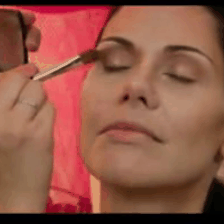

In [ ]:
import imageio
import numpy as np
from IPython.display import Image

def unnormalize_img(img):
    """Un-normalizes the image pixels."""
    img = (img * std) + mean
    img = (img * 255).astype("uint8")
    return img.clip(0, 255)

def create_gif(video_tensor, filename="sample.gif"):
    """Prepares a GIF from a video tensor.
    The video tensor is expected to have the following shape:
    (num_frames, num_channels, height, width).
    """
    frames = []
    for video_frame in video_tensor:
        frame_unnormalized = unnormalize_img(video_frame.permute(1, 2, 0).numpy())
        frames.append(frame_unnormalized)
    kargs = {"duration": 0.25}
    return filename

def display_gif(video_tensor, gif_name="sample.gif"):
    """Prepares and displays a GIF from a video tensor."""
    video_tensor = video_tensor.permute(1, 0, 2, 3)
    gif_filename = create_gif(video_tensor, gif_name)
    return Image(filename=gif_filename)

sample_video = next(iter(train_dataset))
display_gif(sample_video[0])

### Training the model

We'll leverage [`Trainer`](https://huggingface.co/docs/transformers/main_classes/trainer) from  🤗 Transformers for training the model. To instantiate a `Trainer`, we will need to define the training configuration and an evaluation metric. The most important is the [`TrainingArguments`](https://huggingface.co/transformers/main_classes/trainer.html#transformers.TrainingArguments), which is a class that contains all the attributes to configure the training. It requires an output folder name, which will be used to save the checkpoints of the model. It also helps sync all the information in the model repository on 🤗 Hub.

Most of the training arguments are pretty self-explanatory, but one that is quite important here is `remove_unused_columns=False`. This one will drop any features not used by the model's call function. By default it's `True` because usually it's ideal to drop unused feature columns, making it easier to unpack inputs into the model's call function. But, in our case, we need the unused features ('video' in particular) in order to create `pixel_values` (which is a mandatory key our model expects in its inputs).

In [ ]:
from transformers import TrainingArguments, Trainer

model_name = model_ckpt.split("/")[-1]
new_model_name = f"{model_name}-finetuned-ucf101-subset"
num_epochs = 4

args = TrainingArguments(
    new_model_name,
    remove_unused_columns=False,
    eval_strategy="epoch",
    save_strategy="epoch",
    learning_rate=5e-5,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    warmup_ratio=0.1,
    logging_steps=10,
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
    push_to_hub=False,
    max_steps=(len(train_dataset) // batch_size) * num_epochs,
)

There's no need to define `max_steps` when instantiating `TrainingArguments`. Since the dataset returned by `pytorchvideo.data.Ucf101()` doesn't implement the `__len__()` method we had to specify `max_steps`.  

Next, we need to define a function for how to compute the metrics from the predictions, which will just use the `metric` we'll load now. The only preprocessing we have to do is to take the argmax of our predicted logits:

In [29]:
import evaluate

metric = evaluate.load("accuracy")

In [30]:
# the compute_metrics function takes a Named Tuple as input:
# predictions, which are the logits of the model as Numpy arrays,
# and label_ids, which are the ground-truth labels as Numpy arrays.
def compute_metrics(eval_pred):
    """Computes accuracy on a batch of predictions."""
    predictions = np.argmax(eval_pred.predictions, axis=1)
    return metric.compute(predictions=predictions, references=eval_pred.label_ids)

**A note on evaluation**:

In the [VideoMAE paper](https://arxiv.org/abs/2203.12602), the authors use the following evaluation strategy. They evaluate the model on several clips from test videos and apply different crops to those clips and report the aggregate score. However, in the interest of simplicity and brevity, we don't consider that in this tutorial.

We also define a `collate_fn`, which will be used to batch examples together.
Each batch consists of 2 keys, namely `pixel_values` and `labels`.

In [34]:
import torch

def collate_fn(batch):
    # batch: list of (clip, label), clip is (C, T, H, W)
    clips, labels = zip(*batch)
    # stack into (B, C, T, H, W)
    clips = torch.stack(clips)
    # if your model expects (B, T, C, H, W), just permute once:
    pixel_values = clips.permute(0, 2, 1, 3, 4)
    labels = torch.tensor(labels, dtype=torch.long)
    return {"pixel_values": pixel_values, "labels": labels}

Then we just need to pass all of this along with our datasets to the `Trainer`:

In [35]:
trainer = Trainer(
    model,
    args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    tokenizer=image_processor,
    compute_metrics=compute_metrics,
    data_collator=collate_fn,
)

C:\Users\11208120\AppData\Local\Temp\ipykernel_26452\3087471478.py:1: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


You might wonder why we pass along the `image_processor` as a tokenizer when we already preprocessed our data. This is only to make sure the feature extractor configuration file (stored as JSON) will also be uploaded to the repo on the hub.

Now we can finetune our model by calling the `train` method:

In [36]:
train_results = trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy
1,2.129700,1.898651,0.300000
2,1.111900,1.054276,0.566667
3,0.333900,0.434382,0.866667


We can check with the `evaluate` method that our `Trainer` did reload the best model properly (if it was not the last one):

In [37]:
trainer.evaluate(test_dataset)

{'eval_loss': 0.636624276638031,
 'eval_accuracy': 0.8533333333333334,
 'eval_runtime': 28.6744,
 'eval_samples_per_second': 2.616,
 'eval_steps_per_second': 0.349,
 'epoch': 3.8947368421052633}

In [38]:
trainer.save_model()
test_results = trainer.evaluate(test_dataset)
trainer.log_metrics("test", test_results)
trainer.save_metrics("test", test_results)
trainer.save_state()

***** test metrics *****
  epoch                   =     3.8947
  eval_accuracy           =       0.84
  eval_loss               =     0.6541
  eval_runtime            = 0:00:28.46
  eval_samples_per_second =      2.635
  eval_steps_per_second   =      0.351


You can now upload the result of the training to the Hub, just execute this instruction (note that the Trainer will automatically create a model card as well as Tensorboard logs - see the "Training metrics" tab - amazing isn't it?):

In [ ]:
trainer.push_to_hub()

Saving model checkpoint to videomae-base-finetuned-ucf101-subset
Configuration saved in videomae-base-finetuned-ucf101-subset/config.json
Model weights saved in videomae-base-finetuned-ucf101-subset/pytorch_model.bin
Feature extractor saved in videomae-base-finetuned-ucf101-subset/preprocessor_config.json


Upload file runs/Nov10_08-33-15_c4cf3c5cebad/events.out.tfevents.1668069624.c4cf3c5cebad.106.2: 100%|#########…

remote: Scanning LFS files for validity, may be slow...        
remote: LFS file scan complete.        
To https://huggingface.co/sayakpaul/videomae-base-finetuned-ucf101-subset
   e3ebcb5..60d2897  main -> main

remote: LFS file scan complete.        
To https://huggingface.co/sayakpaul/videomae-base-finetuned-ucf101-subset
   e3ebcb5..60d2897  main -> main



'https://huggingface.co/sayakpaul/videomae-base-finetuned-ucf101-subset/commit/60d28970cff3c61201790c839f35a17936df4022'

Now that our model is trained, let's use it to run inference on a video from `test_dataset`. 

## Inference

Let's load the trained model checkpoint and fetch a video from `test_dataset`. 

In [39]:
trained_model = VideoMAEForVideoClassification.from_pretrained(new_model_name)

In [42]:
sample_test_video = next(iter(test_dataset))

We then prepare the video as a `torch.Tensor` and run inference. 

In [50]:
def run_inference(model, video):
    """Utility to run inference given a model and test video.
    
    The video is assumed to be preprocessed already.
    """
    # (num_frames, num_channels, height, width)
    perumuted_sample_test_video = video.permute(1, 0, 2, 3)

    inputs = {
        "pixel_values": perumuted_sample_test_video.unsqueeze(0),
        "labels": torch.tensor(
            [sample_test_video[1]]
        ),  # this can be skipped if you don't have labels available.
    }
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    inputs = {k: v.to(device) for k, v in inputs.items()}
    model = model.to(device)

    # forward pass
    with torch.no_grad():
        outputs = model(**inputs)
        logits = outputs.logits

    return logits

In [51]:
logits = run_inference(trained_model, sample_test_video[0])

We can now check if the model got the prediction right. 

In [55]:
print(sample_test_video[0])

tensor([[[[-0.4911, -0.4911, -0.4911,  ..., -0.5253, -0.5253, -0.5253],
          [-0.4911, -0.4911, -0.4911,  ..., -0.5253, -0.5253, -0.5253],
          [-0.4911, -0.4911, -0.4911,  ..., -0.5253, -0.5253, -0.5253],
          ...,
          [-1.3607, -1.3143, -1.2580,  ...,  1.3873,  1.7442,  1.8672],
          [-1.3607, -1.3143, -1.2580,  ...,  1.3939,  1.7401,  1.8587],
          [-1.3607, -1.3143, -1.2580,  ...,  1.3939,  1.7401,  1.8587]],

         [[-0.4739, -0.4739, -0.4727,  ..., -0.4874, -0.4911, -0.4911],
          [-0.4739, -0.4739, -0.4741,  ..., -0.4874, -0.4911, -0.4911],
          [-0.4739, -0.4739, -0.4752,  ..., -0.4874, -0.4911, -0.4911],
          ...,
          [-1.2164, -1.1760, -1.1614,  ...,  1.6067,  1.5889,  1.5822],
          [-1.2164, -1.1760, -1.1614,  ...,  1.8208,  1.7824,  1.7154],
          [-1.2164, -1.1760, -1.1614,  ...,  1.8770,  1.8013,  1.6960]],

         [[-0.4739, -0.4849, -0.5106,  ..., -0.4715, -0.4911, -0.4911],
          [-0.4758, -0.4880, -

In [ ]:
display_gif(sample_test_video[0])

In [56]:
predicted_class_idx = logits.argmax(-1).item()
print("Predicted class:", model.config.id2label[predicted_class_idx])

Predicted class: ApplyEyeMakeup


And it looks like it got it right!

You can also use this model to bring in your own videos. Check out [this Space](https://huggingface.co/spaces/sayakpaul/video-classification-ucf101-subset) to know more. The Space will also show you how to run inference for a single video file.

<br><div align=center>
    <img src="https://i.ibb.co/7nW4Rkn/sample-results.gif" width=700/>
</div>

## Next steps

Now that you've learned to train a well-performing video classification model on a custom dataset here is some homework for you:

* Increase the dataset size: include more classes and more samples per class. 
* Try out different hyperparameters to study how the model converges.
* Analyze the classes for which the model fails to perform well. 
* Try out a different video encoder.

Don't forget to share your models with the community =)